In [1]:
include("ct_utils.jl")
using ChargeTransport
using .CTUtils
using DataFrames
using CSV 
using PyPlot

println("Libraries imported.")

ERROR: LoadError: TypeError: in new, expected Union{}, got a value of type SparseArrays.SparseMatrixCSC{Float64, Int64}
Stacktrace:
 [1] Sparspak.SpkSparseSolver.SparseSolver(p::SparseArrays.SparseMatrixCSC{Float64, Int64}, slvr::Sparspak.SpkSparseBase._SparseBase{Int64, Float64}, n::Int64, ma::Int64, na::Int64, mc::Int64, nc::Int64, _inmatrixdone::Bool, _orderdone::Bool, _symbolicdone::Bool, _factordone::Bool, _trisolvedone::Bool, _refinedone::Bool, _condestdone::Bool)
   @ Sparspak.SpkSparseSolver ~/.julia/packages/Sparspak/kmobW/src/SparseMethod/SpkSparseSolver.jl:18
 [2] Sparspak.SpkSparseSolver.SparseSolver(m::SparseArrays.SparseMatrixCSC{Float64, Int64})
   @ Sparspak.SparseCSCInterface ~/.julia/packages/Sparspak/kmobW/src/SparseCSCInterface/SparseCSCInterface.jl:185
 [3] sparspaklu(m::SparseArrays.SparseMatrixCSC{Float64, Int64}; factorize::Bool)
   @ Sparspak.SparseCSCInterface ~/.julia/packages/Sparspak/kmobW/src/SparseCSCInterface/SparseCSCInterface.jl:219
 [4] top-level scop

Libraries imported.


In [2]:
choices = ["dark-sc", "illuminated-sc", "illuminated-oc", "illuminated-scaps-oc", "illuminated-ct-oc"]
choice = 4

ct_filename = "../simulation_data/chargetransport/si-topcon-schottky-$(choices[choice]).csv"
scaps_filename = "../simulation_data/scaps/si-topcon-$(choices[choice]).eb"

ct_profile = ct_to_profile(ct_filename)
scaps_profile = parse_scaps(scaps_filename)

println("Data loaded successfully.")

Data loaded successfully.


## Compare Generation

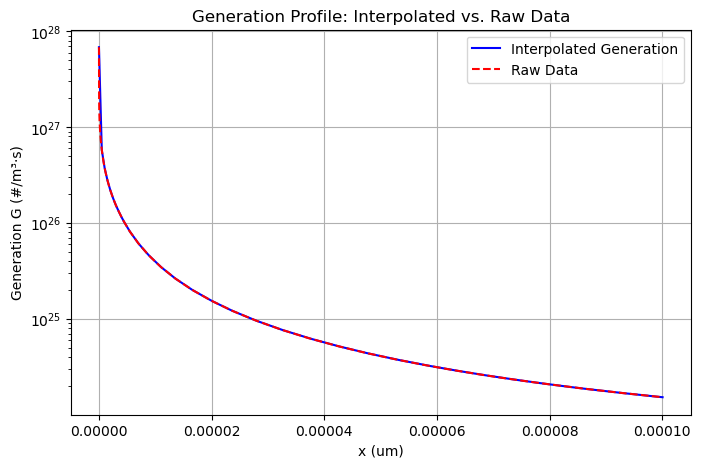

In [2]:
generation_filename = "../simulation_data/scaps/si-topcon-auto.gen"
profile_gen = parse_scaps(generation_filename)

gen_rate = generation_from_scaps(profile_gen)

x_vals = range(minimum(profile_gen.x), stop=maximum(profile_gen.x), length=200)

figure(figsize=(8,5))
plot(x_vals, gen_rate.(x_vals), label="Interpolated Generation", color="blue")
plot(profile_gen.x, profile_gen.G, linestyle="--", label="Raw Data", color="red")

yscale("log")
xlabel("x (um)")
ylabel("Generation G (#/m³·s)")
title("Generation Profile: Interpolated vs. Raw Data")
legend()
grid(true)
display(gcf())

## Compare Densities

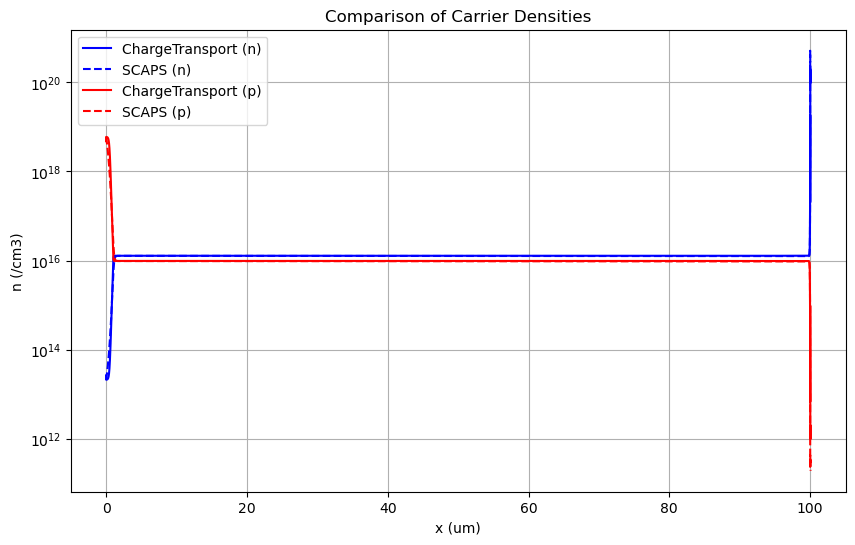

In [20]:
compare_densities(ct_filename, scaps_filename)
display(gcf())

## Compare Bands

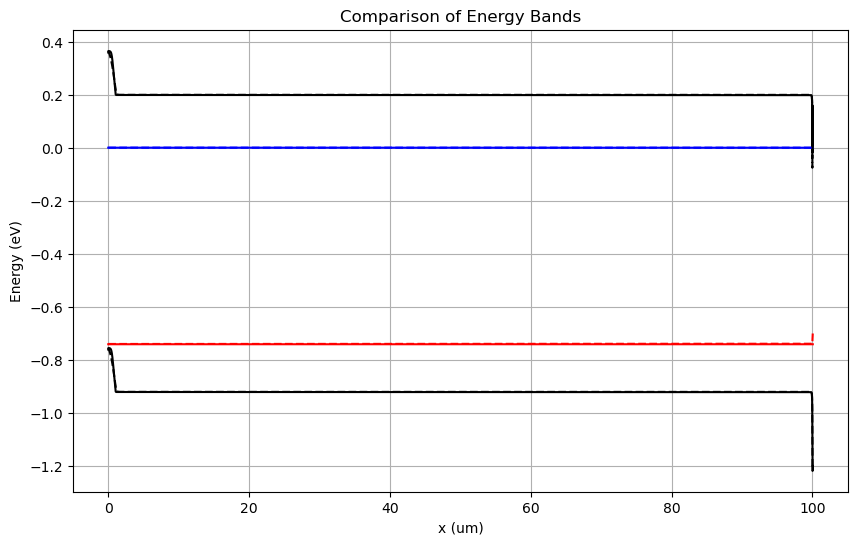

In [21]:
compare_bands(ct_profile, scaps_profile)
display(gcf())

In [6]:
ct_voltage = ct_profile.Efn[end] - ct_profile.Efp[1]
scaps_voltage = scaps_profile.Efn[end] - scaps_profile.Efp[1]

0.8379999899999999

In [8]:
scaps_voltage

0.8379999899999999

## Compare IV Curves

In [6]:
ct_iv_file = "../simulation_data/chargetransport/si-topcon-schottky-iv.csv"
scaps_iv_file = "../simulation_data/scaps/si-topcon.iv"


ct_profile.IV = set_IV!(ct_profile, ct_iv_file)
scaps_profile.IV = set_IV!(scaps_profile, scaps_iv_file)

41×2 Matrix{Float64}:
 0.0   -37.8668
 0.02  -37.8668
 0.04  -37.8668
 0.06  -37.8668
 0.08  -37.8668
 0.1   -37.8668
 0.12  -37.8668
 0.14  -37.8667
 0.16  -37.8667
 0.18  -37.8667
 ⋮     
 0.64  -36.5883
 0.66  -35.0692
 0.68  -31.7003
 0.7   -24.1384
 0.72   -6.89959
 0.74   33.1528
 0.76  128.26
 0.78  359.107
 0.8   928.913

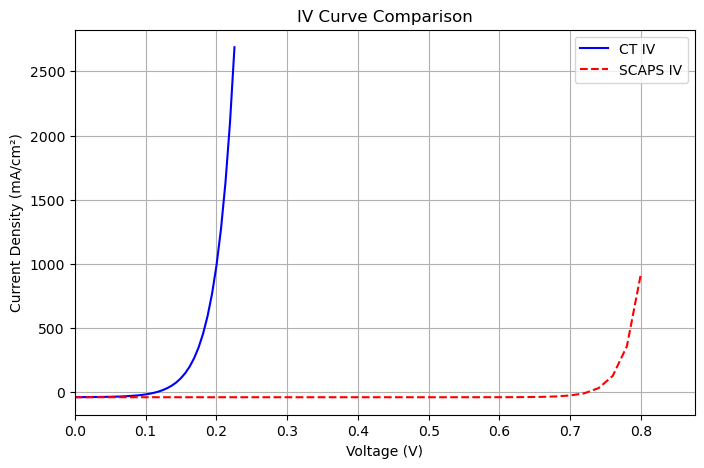

In [ ]:
figure(figsize=(8,5))
plot(ct_profile.IV[:, 1] .- (0.8385 - 0.7244), ct_profile.IV[:, 2] .* -1e-1, label="CT IV", color="blue")
plot(scaps_profile.IV[:, 1], scaps_profile.IV[:, 2], label="SCAPS IV", color="red", linestyle="--")

xlim(0, nothing)
xlabel("Voltage (V)")
ylabel("Current Density (mA/cm²)")
title("IV Curve Comparison")
legend()
grid(true)
display(gcf())